In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./backend')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

import sglm
import sglm_cv
import sglm_pp
import sglm_test

ModuleNotFoundError: No module named 'sglm_test'

# Loading in the DesignMatrix (and response) Data

In [ ]:
df = pd.read_csv('../C39v2_sampleDesignMat.csv').drop('Unnamed: 0', axis=1).drop('index', axis=1)

# Converting photometry response to a differential rather than raw output

,grnL,grnL_diff
0,921.93774,921.93774
1,950.58765,28.64991
2,944.09120,-6.49645
3,948.26196,4.17076
4,945.38464,-2.87732


Text(0.5, 0, 'Timestep Index')

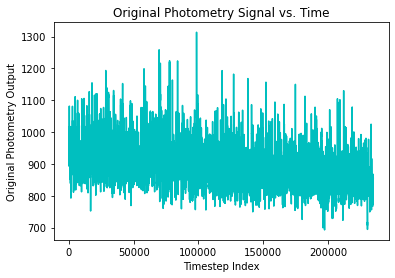

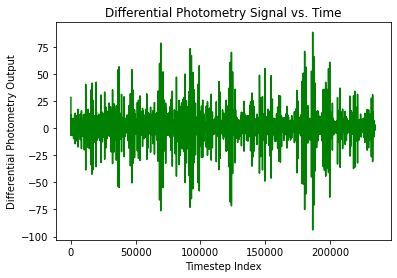

In [ ]:
y_setup_col = 'grnL' # photometry response
df['grnL_diff'] = sglm_pp.diff(df['grnL'])

# Demonstrative first 5 timesteps of photometry signal vs. differential
display(df[['grnL', 'grnL_diff']].head())

# Plotting original photometry output (excluding first timestep)
plt.figure()
df['grnL'].iloc[1:].plot(color='c')
plt.title('Original Photometry Signal vs. Time')
plt.ylabel('Original Photometry Output')
plt.xlabel('Timestep Index')

# Plotting photometry differential output (excluding first timestep)
plt.figure()
df['grnL_diff'].iloc[1:].plot(color='g')
plt.title('Differential Photometry Signal vs. Time')
plt.ylabel('Differential Photometry Output')
plt.xlabel('Timestep Index')

# Specifying columns to retain for GLM fitting

In [ ]:
X_cols = [
    'nTrial', # trial ID
    'iBlock', # block number within session
    'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1)
    'ENLPenalty', # lick during ENL period (no directionality yet, 0,1)
    'Select', # binary selection lick
    'Consumption', # consumption period (from task perspective)
    'TO', # timeout trial
    'responseTime', # task state cue to selection window
    'ENL', # task state ENL window
    'Cue', # task state Cue window
    'decision', # choice lick direction (aligned to select but with directionality -1,1)
    'switch', # switch from previous choice on selection (-1,1)
    'selR', # select reward (-1,1) aligned to selection
    'selHigh', # select higher probability port (-1,1)
    'Reward', # reward vs no reward during consumption period (-1,1)
    'post', # log-odds probability
]

y_col = 'grnL_diff'

# Keep only relevant columns specified above

In [ ]:
dfrel = df[X_cols + [y_col]].copy()
dfrel = dfrel.replace('False', 0).astype(float)
dfrel = dfrel*1

X_setup = dfrel[X_cols]
y_setup = dfrel[y_col]

# Timeshift all non-response columns forward and backward ts timesteps

In [ ]:
# ts = 10
ts = 2

shift_amt_list = [0]
shift_amt_list += list(range(-ts, 0))
shift_amt_list += list(range(1, ts+1))

dfrel = sglm_pp.timeshift_multiple(X_setup, shift_amt_list=shift_amt_list)

with pd.option_context('max_columns',None):
    print('Example First 5 Rows of Timeshifted Columns:')
    display(dfrel[['Cue', 'Cue_1', 'Cue_2', 'Cue_-1', 'Cue_-2']].head())
    print('Example Last 5 Rows of Timeshifted Columns:')
    display(dfrel[['Cue', 'Cue_1', 'Cue_2', 'Cue_-1', 'Cue_-2']].tail())

Example First 5 Rows of Timeshifted Columns:


,Cue,Cue_1,Cue_2,Cue_-1,Cue_-2
0,0.0,NaN,NaN,0.0,0.0
1,0.0,0.0,NaN,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


Example Last 5 Rows of Timeshifted Columns:


,Cue,Cue_1,Cue_2,Cue_-1,Cue_-2
234923,0.0,0.0,0.0,0.0,0.0
234924,0.0,0.0,0.0,0.0,0.0
234925,0.0,0.0,0.0,0.0,0.0
234926,0.0,0.0,0.0,0.0,NaN
234927,0.0,0.0,0.0,NaN,NaN


# Drop first column due to response "diff" and all NA columns generated from timeshifts

In [ ]:
full_dataset = dfrel.copy()
full_dataset['grnL_diff'] = y_setup
full_dataset['grnL_sft'] = y_setup.shift(1)
full_dataset['grnL_sft2'] = y_setup.shift(2)
full_dataset = full_dataset.iloc[5:]
full_dataset = full_dataset.dropna().copy()

full_dataset.head()

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,...,Cue_2,decision_2,switch_2,selR_2,selHigh_2,Reward_2,post_2,grnL_diff,grnL_sft,grnL_sft2
5,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.04456,-2.87732,4.17076
6,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.15564,2.04456,-2.87732
7,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.04024,-2.15564,2.04456
8,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.97560,1.04024,-2.15564
9,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.39340,-1.97560,1.04024


In [ ]:
X = full_dataset.drop(y_col, axis=1)
y = full_dataset[y_col]

# Fit GLM with predictors X and response y

## SKLearn-based Implementation (No Cross-Validation)

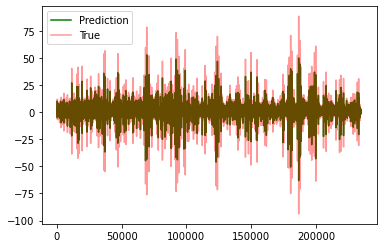

In [ ]:

glm3 = sglm.SKGLM('Normal', max_iter=10000, alpha=0)
glm3.fit(X.values[1:], y.values[1:])

pred = glm3.model.predict(X.values)
true = y.values

# plt.plot(pred[:1000], color='g')
# plt.plot(true[:1000], alpha = 0.4, color='r')
plt.plot(pred[:], color='g', label='Prediction')
plt.plot(true[:], alpha = 0.4, color='r', label='True')
plt.legend()

In [ ]:
print('Stats Model AIC')
import statsmodels.api as sm
X2 = sm.add_constant(X)
srl = sm.OLS(y, X2)
results = srl.fit()
results.aic

# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py#L1822

# Difference caused by SKLearn's tolerance parameter in fitting descent process

# llf = glm3.log_likelihood(pred, true)
# df_modelwc = X.shape[-1] + 1
# nobs = X.shape[0] - 1

pred_sm = results.predict(X2)
print('Stats Model Fit — Log Likelihood:', results.llf)
print('Stats Model Fit — By Hand Log Likelihood:', glm3.log_likelihood(pred_sm, true))


print('AIC by Hand:', 2*(X.shape[-1] + 1) - 2*glm3.log_likelihood(pred, true))
# # print(-2.0 * llf + 2.0 * df_modelwc * nobs / (nobs - df_modelwc - 1.0))
# print(np.std(true - pred) + (-2.0 * llf + 2.0 * df_modelwc) / nobs)
# print(-2.0 * llf + 2.0 * df_modelwc * nobs / (nobs - df_modelwc - 1.0))

print('Stats Model AIC', results.aic)



Stats Model AIC
Stats Model Fit — Log Likelihood: -426357.18136291485
Stats Model Fit — By Hand Log Likelihood: -426357.1813629149
AIC by Hand: 852882.668637965
Stats Model AIC 852870.3627258297


In [ ]:
glm4 = sglm.SKGLM('Logistic', max_iter=10000, C=100000000)
glm4.fit(X.values[:,:6], y.values[:] > 0)

pred4 = glm4.model.predict_proba(X.values[:,:6])[:,1]
true4 = y.values > 0


# glm4.log_likelihood(pred4, true4)
# np.sum(true4 * np.log(pred4) + (1-true4)*np.log(1-pred4))

import statsmodels.api as sm
X2 = sm.add_constant(X.iloc[:,:6])
srl = sm.Logit(y > 0, X2)
results = srl.fit()

print()

print('AIC by Hand:', 2*(X.values[:,:6].shape[-1] + 1) - 2*glm4.log_likelihood(pred4, true4))
print('Stats Model AIC', results.aic)

# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/linear_model.py#L1822

Optimization terminated successfully.
         Current function value: 0.679118
         Iterations 13

AIC by Hand: 319096.43313799205
Stats Model AIC 319092.052636612


## Running Cross-Validation for Parameter Selection

In [ ]:
# Examine Keyword Parameters for Tweedie Regression (upon which SKGLM is based):
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html

# For demonstration, let's cross validate L2 regularization strength "alpha", whether or not to
# "fit_intercept", and do both of these with a fixed 'link'='auto' and a larger fixed
# max iteration number, "max_iter"

In [ ]:
# Step 1: Create time buckets of 1000 entries each (actual value will vary based on
# sampling rate and amount of time desired for bucketing)
num_buckets = X.shape[0] // 1000
print('Num Buckets:', num_buckets)

slice_ids = np.arange(X.shape[0]) // num_buckets
print('Slice IDs:', slice_ids)

Num Buckets: 234
Slice IDs: [   0    0    0 ... 1003 1003 1003]


In [ ]:
# Step 2: Create index sets for each of the K-folds based on prior groupings
splitter = GroupShuffleSplit(n_splits=5)
cv_idx = list(splitter.split(X, y, slice_ids))

In [ ]:
# Step 1: Create a dictionary of lists for these relevant keywords...
kwargs_iterations = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}

# Step 2: Create a dictionary for the fixed keyword arguments that do not require iteration...
kwargs_fixed = {
    'link': 'auto',
    'max_iter': 1000
}

# Step 3: Generate iterable list of keyword sets for possible combinations
glm_kwarg_lst = sglm_cv.generate_mult_params(kwargs_iterations, kwargs_fixed)

display(glm_kwarg_lst)

[{'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': False},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': True},
 {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': False}]

In [ ]:
# Step 4: Fit GLM models for all possible sets of values
cv_results = sglm_cv.cv_glm_mult_params(X.values,
                                        y.values,
                                        cv_idx,
                                        'Normal',
                                        glm_kwarg_lst,
                                        GLM_CLS=sglm.SKGLM,
                                        verbose=1)

best_score = cv_results['best_score']
best_params = cv_results['best_params']

Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.1, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 1.0, 'fit_intercept': False}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': True}
Completing arguments: {'link': 'auto', 'max_iter': 1000, 'alpha': 10.0, 'fit_intercept': False}


In [ ]:
print(f"Best Score: {best_score} — Given By: {best_params}")

Best Score: 0.601 — Given By: {'link': 'auto', 'max_iter': 1000, 'alpha': 0.01, 'fit_intercept': False}


In [ ]:
np.isnan(y.values).sum()

0

## Pyglmnet-based Implementation — (Needs debuggging)

Example Predictions: [-0.00052633 -0.00052633 -0.00052633 ... -0.00052633 -0.00052633
 -0.00052633]


/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


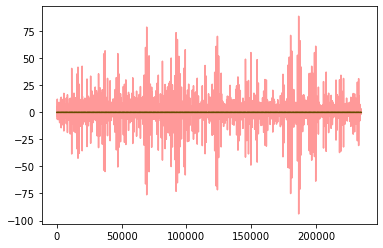

In [ ]:
# glm = sglm.GLM('Normal', verbose=False, alpha=0.05,
#             max_iter=10000, learning_rate=2e-8, score_metric='pseudo_R2',
#             reg_lambda=1e-100, eta=0)
glm = sglm.GLM('Normal', reg_lambda=0, alpha=0.5)
glm.fit(np.float64(X.values[1:, 4:5]), np.float64(y.values[1:]))

print('Example Predictions:', glm.model.predict(X.values[1:, 4:5]))

# plt.plot(pred[:1000], color='g')
# plt.plot(true[:1000], alpha = 0.4, color='r')
plt.plot(glm.model.predict(X.values[1:, 4:5]), color='g')
plt.plot(y.values[1:], alpha = 0.4, color='r')


In [ ]:

plt.plot(glm.model.predict(X.values), color='g')
plt.plot(y.values, alpha = 0.4, color='r')


ValueError: shapes (234921,82) and (1,) not aligned: 82 (dim 1) != 1 (dim 0)

In [ ]:
X.values[:, 0]

array([  4.,   4.,   4., ..., 239., 239., 239.])